In [1]:
import re
import glob
import matplotlib.pyplot as plt
from itertools import cycle
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

plt.style.use('ggplot')

In [2]:
def get_event(file: str):
    event = EventAccumulator(file)
    event.Reload()
    return event

In [3]:
def get_log_metric(event: EventAccumulator, metric: str):
    
    _, step, value = zip(*event.Scalars(metric))
    
    return step, value

In [4]:
def plot_and_save_metrics(
    files: list,
    metric: str,
    hp: str,
    hp_position: int,
    path_prefix: str,
    filename: str
):
    color_codes = map('C{}'.format, cycle(range(len(files))))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    for file in files:
        txt = re.sub(path_prefix + "model_", "", file)
        txt = re.sub(r"/version_\d+/", "", txt)
        txt = txt.split("_")
        label = f"{hp}: {txt.pop(hp_position)}"
        event = get_event(file)
        step, value = get_log_metric(event, metric)
        plt.plot(
            step,
            value,
            color=next(color_codes),
            label=label
        )

    if 'loss' in metric:
        ax.legend(loc='upper right', fontsize='medium')
    else:
        ax.legend(loc='lower right', fontsize='medium')
        
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    plt.show()

    fig.savefig(
        f'../images/results/{filename}.png',
        transparent=False,
        dpi=400,
        bbox_inches="tight"
    )

In [5]:
path_prefix = "../data/logs/grid_logs_with_acc/"
filepath = f'{path_prefix}*'
files = glob.glob(
    filepath + '/**/version_*/',
    recursive=True
)
len(files)

108

In [6]:
metrics = [
    "avg_training_loss",
    "avg_validation_loss",
    "avg_training_acc",
    "avg_validation_acc"    
]
configs = {
    "batch_var": {
        "files": [f for f in files if "64" in f and "0.05" in f and "0.0005" in f],
        "hp": "batch size",
        "hp_position": 0,
        "filename": "batch_var_{metric}"
    },
    "hidden_dim_var": {
        "files": [f for f in files if "512" in f and "0.05" in f and "0.0005" in f],
        "hp": "hidden dim",
        "hp_position": 1,
        "filename": "hidden_dim_var_{metric}"
    },
    "dropout_var": {
        "files": [f for f in files if "512" in f and "64" in f and "0.0005" in f and '0.08' not in f],
        "hp": "dropout",
        "hp_position": 2,
        "filename": "dropout_var_{metric}"
    },
    "learning_rate_var": {
        "files": [f for f in files if "512" in f and "64" in f and "0.05" in f],
        "hp": "learning rate",
        "hp_position": 3,
        "filename": "learning_rate_var_{metric}"
    }
}

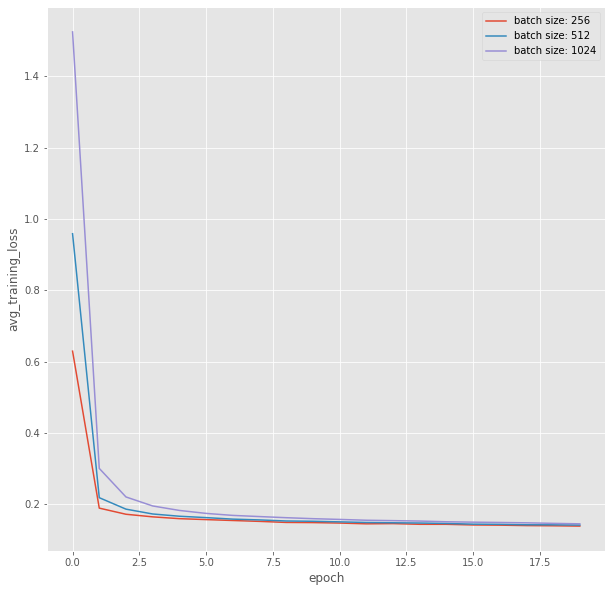

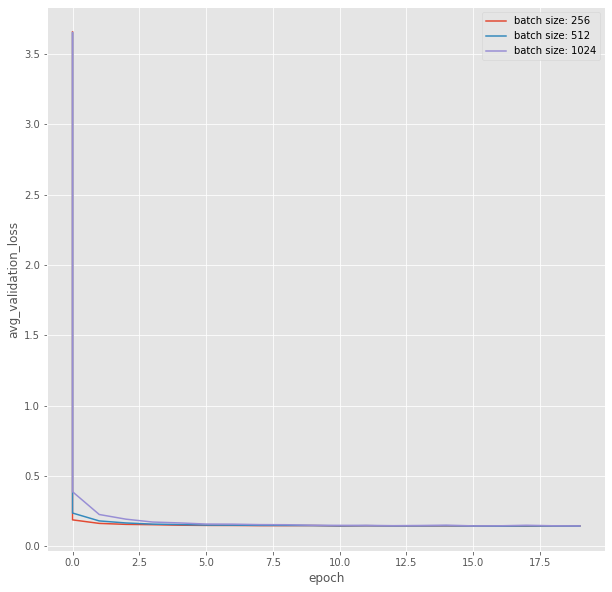

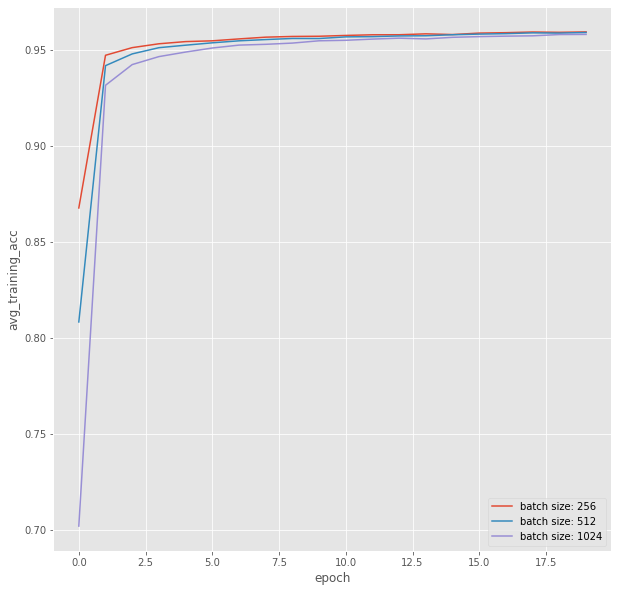

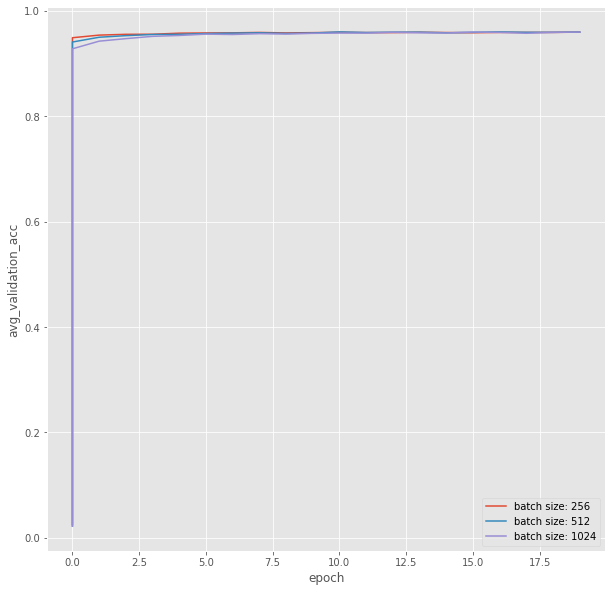

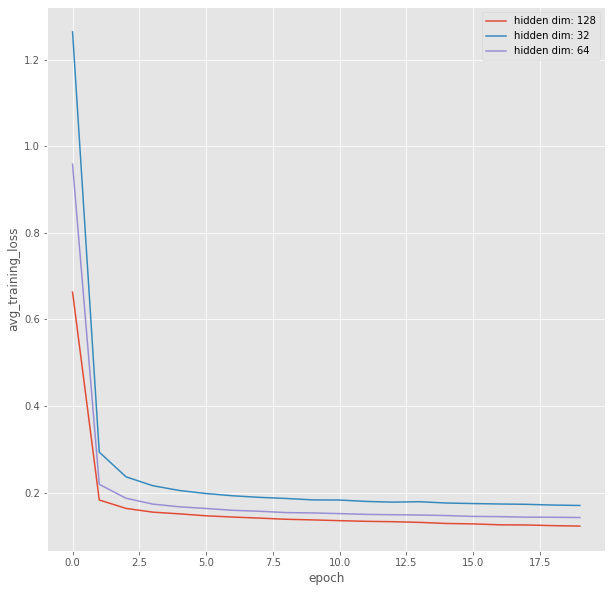

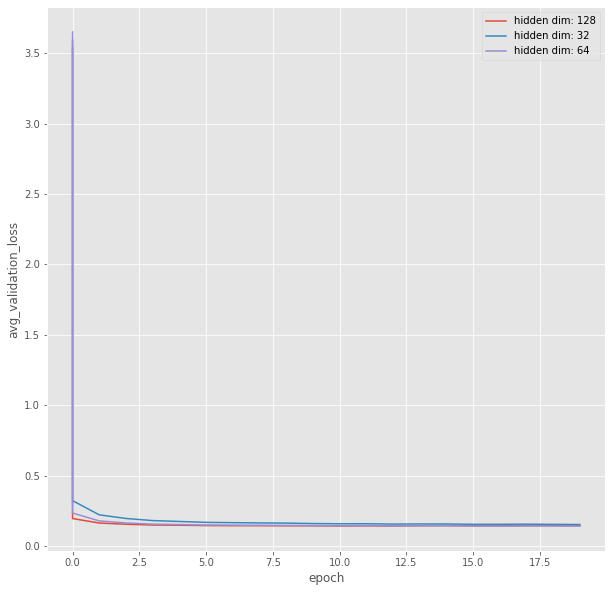

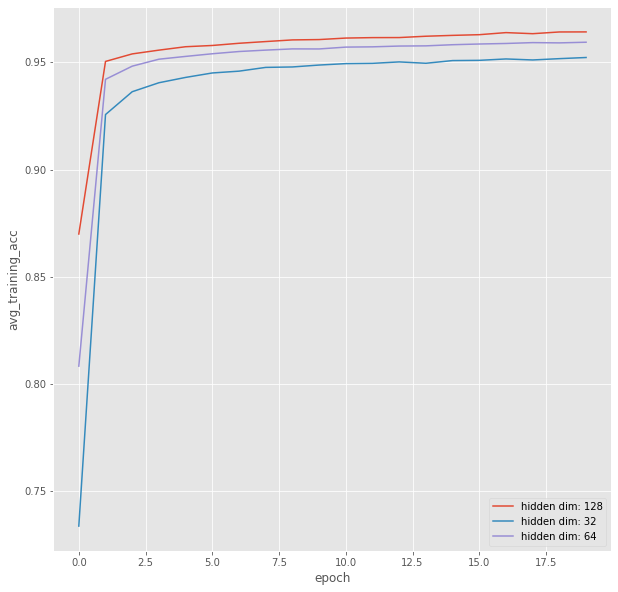

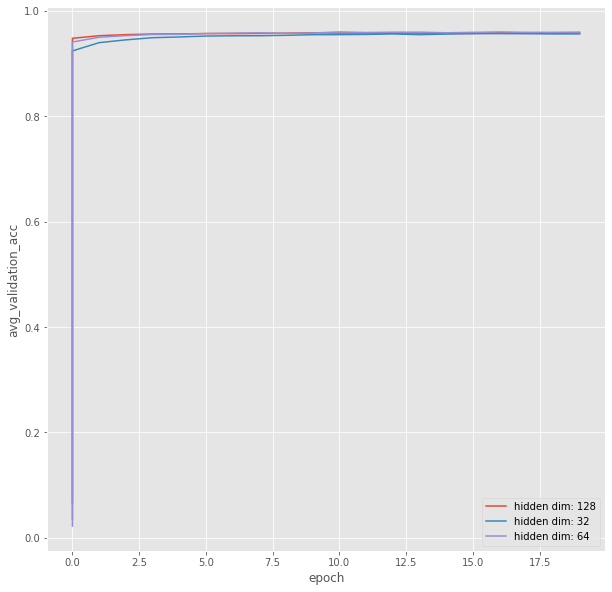

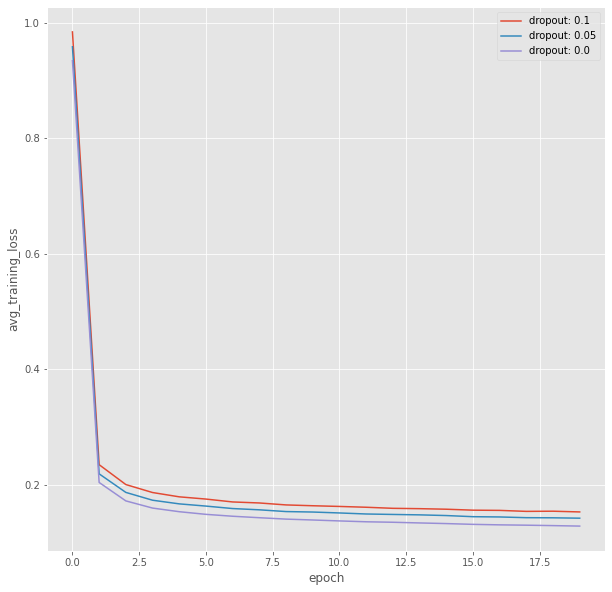

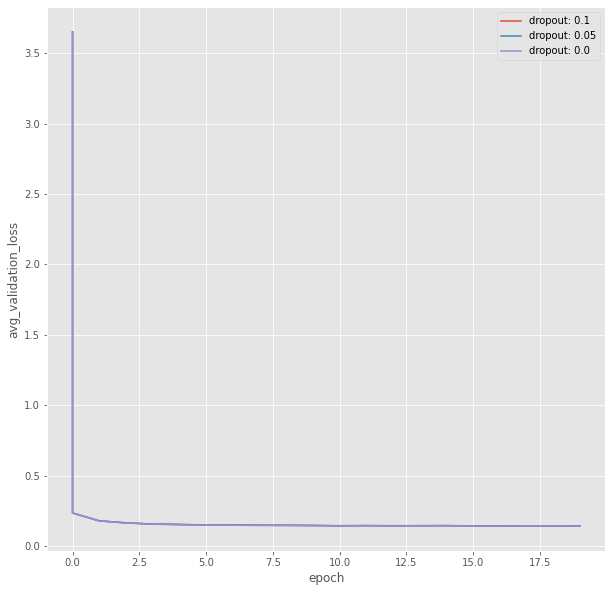

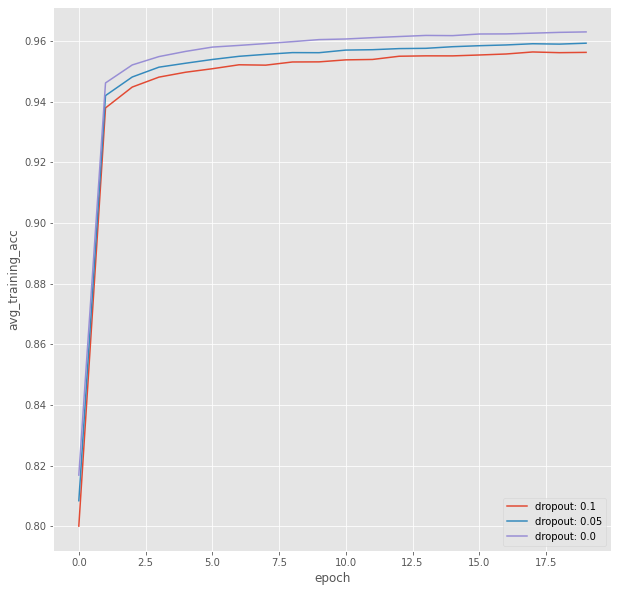

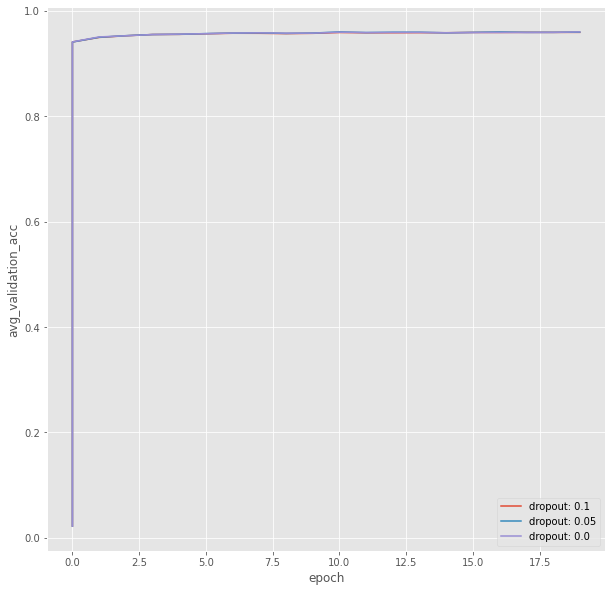

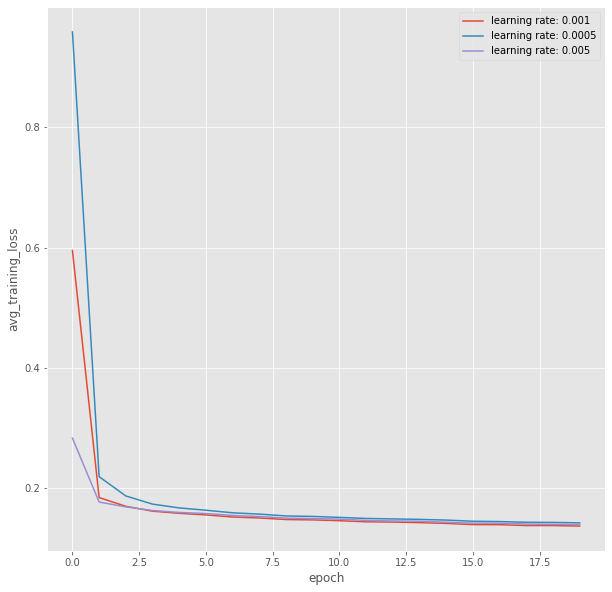

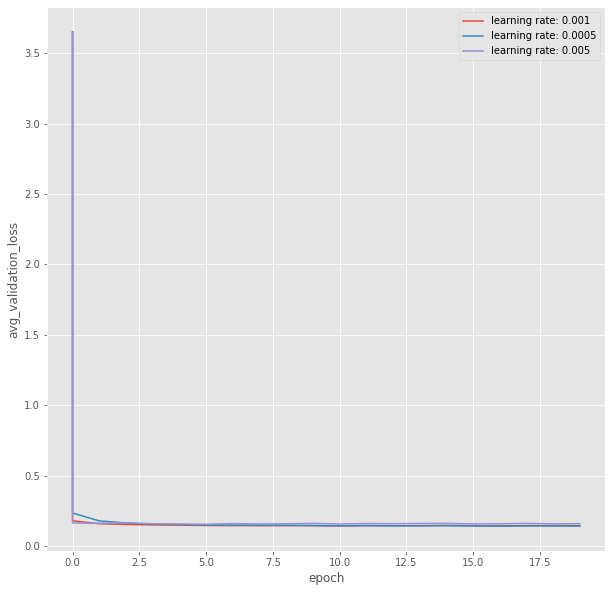

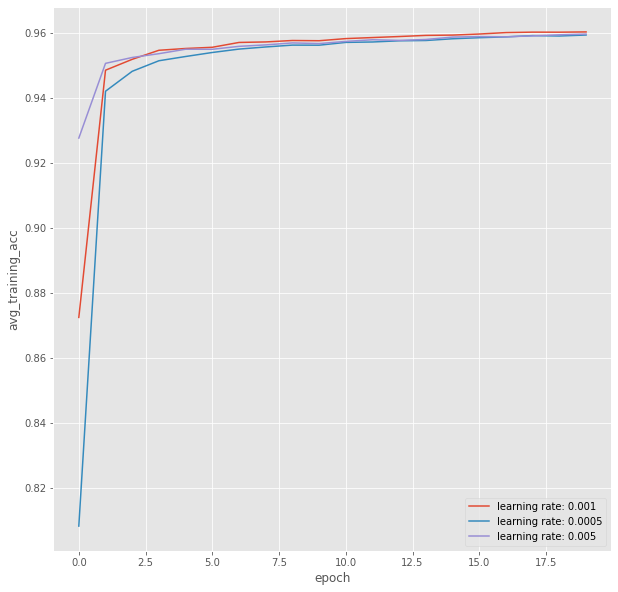

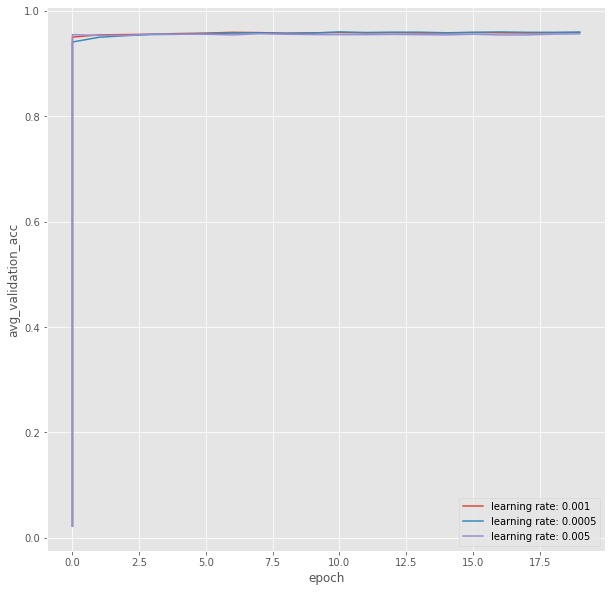

In [7]:
for c in configs.keys():
    for metric in metrics:
        plot_and_save_metrics(
            configs[c]["files"],
            metric,
            configs[c]["hp"],
            configs[c]["hp_position"],
            path_prefix,
            configs[c]["filename"].format(metric=metric)
        )

### Best model

In [8]:
def plot_and_save_best_model_metrics(file: str, metrics: list, path_prefix: str):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    event = get_event(file)
    
    metrics_dict = {}
    
    for metric in metrics:
        step, value = get_log_metric(event, metric)
        metrics_dict[metric] = value[-1]
        plt.plot(step, value, label=metric)

    
    filename = re.sub(path_prefix, "", file)
    filename = re.sub(r"/version_\d+/", "", filename)
    
    if "loss" in metric:
        ax.legend(loc='upper right', fontsize='medium')
        ax.set_ylabel('loss')
        filename += "_loss"
    if "acc" in metric:
        ax.legend(loc='lower right', fontsize='medium')
        ax.set_ylabel('accuracy')
        filename += "_acc"
    ax.set_xlabel('epoch')
    plt.show()
    
    fig.savefig(
        f'../images/results/best_{filename}.png',
        transparent=False,
        dpi=400,
        bbox_inches="tight"
    )
    
    return metrics_dict

In [9]:
[f for f in files if "512" in f and "64" in f and "0.05" in f and "0.0005" in f]

['../data/logs/grid_logs_with_acc/model_512_64_0.05_0.0005/version_0/']

In [10]:
loss_metrics = [
    "avg_training_loss",
    "avg_validation_loss",
    "avg_test_loss"
]
acc_metrics = [
    "avg_training_acc",
    "avg_validation_acc",
    "avg_test_acc"
]

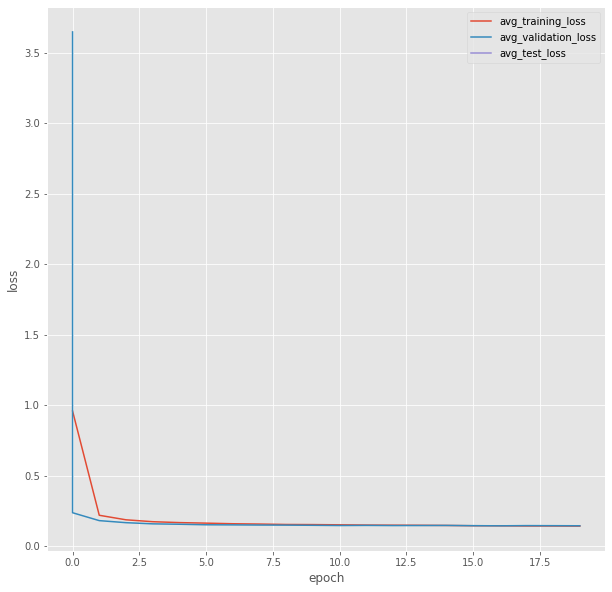

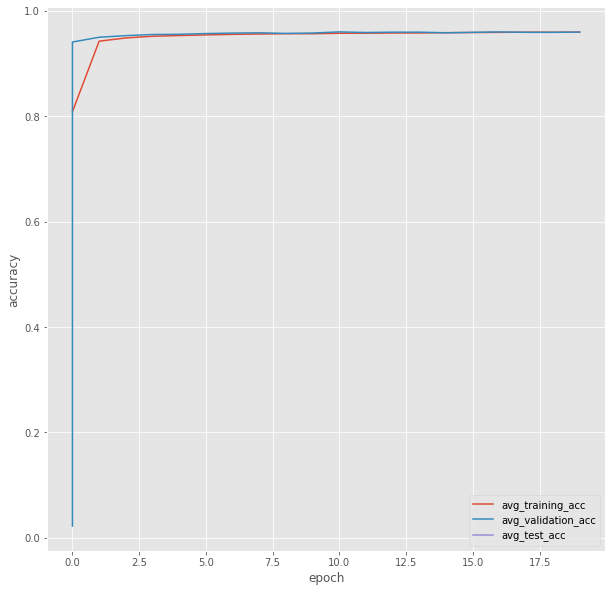

In [11]:
loss_results = plot_and_save_best_model_metrics(
    "../data/logs/grid_logs_with_acc/model_512_64_0.05_0.0005/version_0/",
    loss_metrics,
    path_prefix
)
acc_results = plot_and_save_best_model_metrics(
    "../data/logs/grid_logs_with_acc/model_512_64_0.05_0.0005/version_0/",
    acc_metrics,
    path_prefix
)

In [12]:
loss_results

{'avg_training_loss': 0.14216655492782593,
 'avg_validation_loss': 0.14444175362586975,
 'avg_test_loss': 0.1541169285774231}

In [13]:
acc_results

{'avg_training_acc': 0.9593605995178223,
 'avg_validation_acc': 0.9592830538749695,
 'avg_test_acc': 0.9567954540252686}